## 1-1. Data を読み込んでみよう

In [1]:
# Data を読み込む
import pandas as pd

df_info = pd.read_csv('accomodation_info.csv', index_col=0, parse_dates=[0])
df_info

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:02:21,110034,若松 花子,B,19000
2018-11-01 00:03:10,112804,津田 美加子,D,20000
2018-11-01 00:06:19,110275,吉本 美加子,D,20000
2018-11-01 00:08:41,110169,坂本 直人,B,19000
2018-11-01 00:12:22,111504,青山 零,A,15000
...,...,...,...,...
2020-10-31 23:38:51,110049,吉本 篤司,A,3000
2020-10-31 23:42:12,110127,喜嶋 浩,A,3000
2020-10-31 23:47:24,115464,藤本 明美,D,8000


- 宿泊料金は、曜日や季節によって変動する。
    ※ コロナウイルス感染症の流行後は大幅な値下げを行なっている。
- Plan は４つあり、感染症流行前は、Restaurant での朝夕食付き Plan が人気だった。

| Plan | 内容          |
|------|-------------|
| A    | 素泊まり        |
| B    | 朝夕食付        |
| C    | 素泊まり露天風呂付客室 |
| D    | 朝夕食付露天風呂付客室 |

## 1-2. 時系列 Data を可視化してみよう
Data の大まかな全体像をつかむためと
- **「時間」**: 全体の数字が時間的にどのように変化しているか
- **「分布」**: 統計的にどのように分布しているか

という２つの軸で捉える。

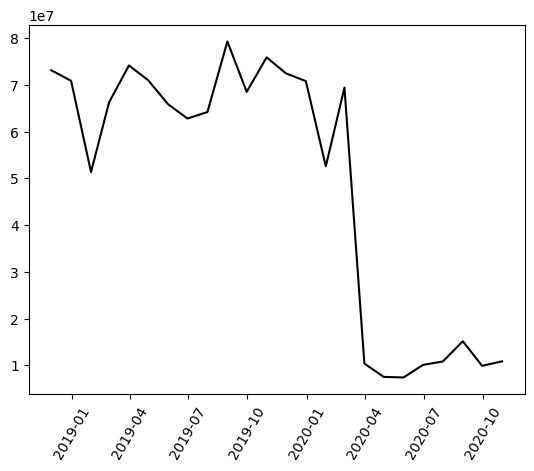

In [2]:
# 月ごとの売上を可視化する
import matplotlib.pyplot as plt
plt.plot(df_info['金額'].resample('M').sum(), color='k')
plt.xticks(rotation=60)
plt.show()

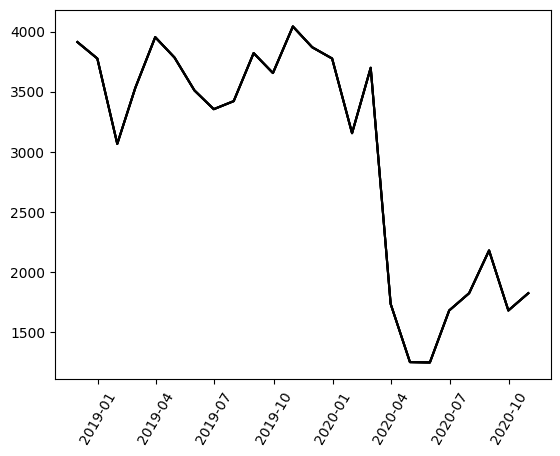

In [3]:
# 月ごとの利用者を可視化する
plt.plot(df_info.resample('M').count(), color='k')
plt.xticks(rotation=60)
plt.show()

売上も利用者も、感染症流行を経て激減している。

## 1-3. 平均値、中央値、最小値、最大値を出力してみよう
どのような利用者がいるのか全体像を把握するために、各利用者の統計値を確認する。

In [4]:
# 平均値、中央値、最小値、最大値の出力を行なう
x_mean = df_info['顧客ID'].value_counts().mean()
x_median = df_info['顧客ID'].value_counts().median()
x_min = df_info['顧客ID'].value_counts().min()
x_max = df_info['顧客ID'].value_counts().max()
print('平均値:', x_mean)
print('中央値:', x_median)
print('最小値:', x_min)
print('最大値:', x_max)

平均値: 13.073641997812613
中央値: 7.0
最小値: 1
最大値: 184


平均値が１３回なのに対して中央値が７回と大きく値がずれている。
利用者の利用回数が一様に分布していれば（利用回数が多い人も少ない人も、一様に存在すれば）平均値と中央値は概ね一致するので、利用回数の多少がまばらに分布しているなど、分布に偏りが見られると推測される。
実際に、最小値が１なのに対して最大値が 184, と最大値が平均値が遠い位置にあるため最小値に近い位置に利用回数が集中しており、最大値に近いところはまばらに点在しているのではないかと予想される。

## 1-4. 分布の形を見てみよう

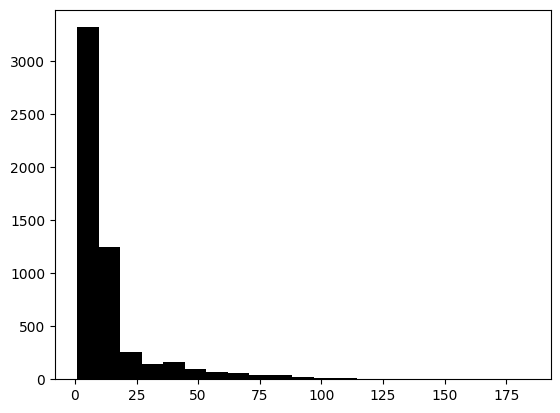

In [5]:
# 分布の可視化を行なう
x = df_info['顧客ID'].value_counts()
x_hist, t_hist,_ = plt.hist(x, 21, color='k')  # 第2引数は、最大値と最小値の間を分ける区間を設定
plt.show()

x軸: 利用頻度
y軸: 利用者数

ほどんどの利用者は１回のみ、あるいはごく少数の利用のみで少数だけ極めて多い回数の利用者が存在する。
※平均値が最小値側に大幅に偏っている理由

> #### べき分布
> ０付近に多くの Sample数が集中し、それ以降、急激に減少していく分布。

## 1-5. 分布の近似曲線を求めてみよう
分析している Data がどのような数式に基づく分布に従うのかを求め、Histogram 上に **「近似曲線」** を引き説得力を上げる。

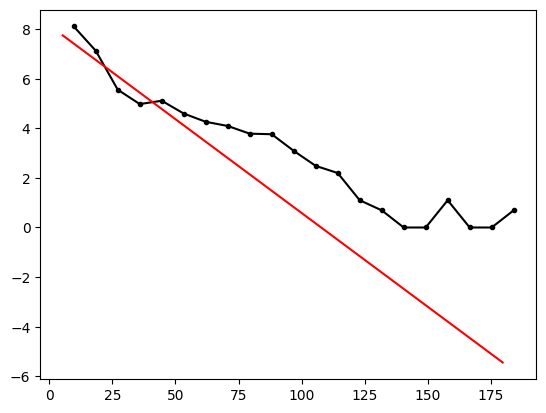

In [6]:
# 近似曲線の Parameter を算出する
import numpy as np

# Parameter 設定
epsiron = 1  # x_hist の値が 0 だった場合、log をとると負の無限大に発散してしまうため、回避するために足しあわせる便宜上の値
num = 15  # Fitting の区間を全体ではなく num で指定

# 変数設定
weight = x_hist[1:num]
t = np.zeros(len(t_hist) - 1)  # t_hist は、各区間の端点を表すため、区間の中心点を表す t に変換
for i in range(len(t_hist) - 1):
    t[i] = (t_hist[i] + t_hist[i + 1]) / 2

# Fitting（最小二乗近似）による Parameter の算出
a, b = np.polyfit(t[1:num], np.log(x_hist[1:num]), 1, w=weight)
    # log p(x) = ax + b の Parameter の a, b を同時に求める
    # x には t を指定
    # y には x_hist の log をとったものである np.log(x_hist[1:num]) を指定
    # w  x_hist[1:num] を指定し縦軸の値が大きいほど近似曲線に Fitting する際の重みを強めるように指定

# Fitting曲線（直線）の描画
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = a * t[i] + b
plt.plot(t_hist[1:], np.log(x_hist + epsiron), marker='.', color='k')
plt.plot(t, xt, color='r')
plt.show()

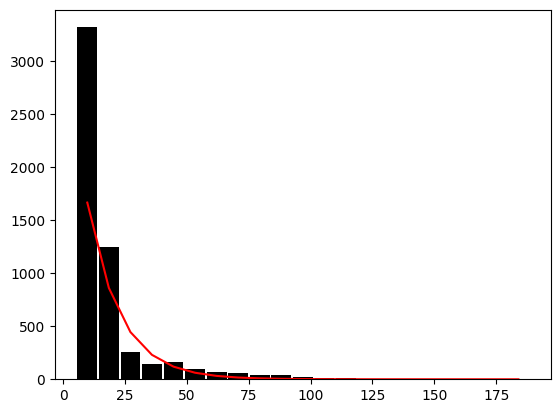

In [7]:
# 近似曲線を描く
import math

t = t_hist[1:]
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = math.exp(a * t[i] + b)

plt.bar(t_hist[1:], x_hist, width=8, color='k')
plt.plot(t, xt, color='r')
plt.show()

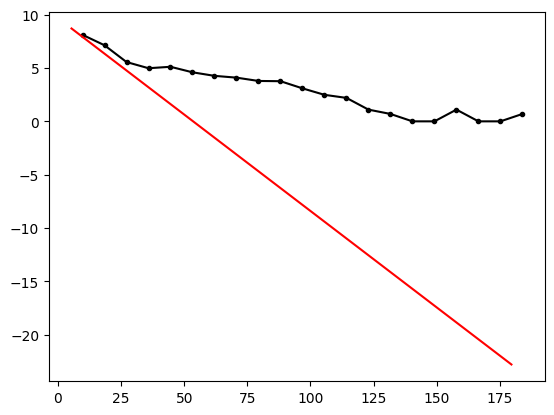

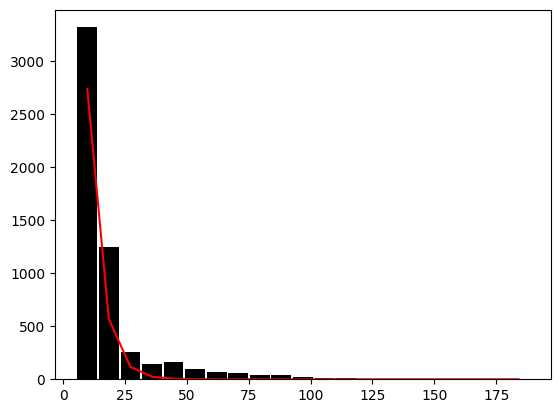

In [8]:
# 左側の Fitting を良く見せるため num を小さくする

# 近似曲線の Parameter を算出する
import numpy as np

# Parameter 設定
epsiron = 1  # x_hist の値が 0 だった場合、log をとると負の無限大に発散してしまうため、回避するために足しあわせる便宜上の値
num = 3  # Fitting の区間を全体ではなく num で指定

# 変数設定
weight = x_hist[1:num]
t = np.zeros(len(t_hist) - 1)  # t_hist は、各区間の端点を表すため、区間の中心点を表す t に変換
for i in range(len(t_hist) - 1):
    t[i] = (t_hist[i] + t_hist[i + 1]) / 2

# Fitting（最小二乗近似）による Parameter の算出
a, b = np.polyfit(t[1:num], np.log(x_hist[1:num]), 1, w=weight)
    # log p(x) = ax + b の Parameter の a, b を同時に求める
    # x には t を指定
    # y には x_hist の log をとったものである np.log(x_hist[1:num]) を指定
    # w  x_hist[1:num] を指定し縦軸の値が大きいほど近似曲線に Fitting する際の重みを強めるように指定

# Fitting曲線（直線）の描画
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = a * t[i] + b
plt.plot(t_hist[1:], np.log(x_hist + epsiron), marker='.', color='k')
plt.plot(t, xt, color='r')
plt.show()

# 近似曲線を描く
import math

t = t_hist[1:]
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = math.exp(a * t[i] + b)

plt.bar(t_hist[1:], x_hist, width=8, color='k')
plt.plot(t, xt, color='r')
plt.show()

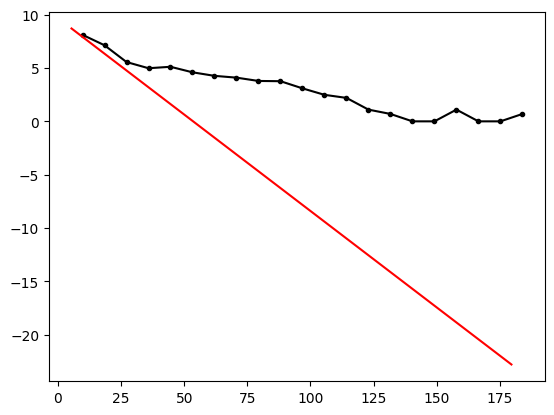

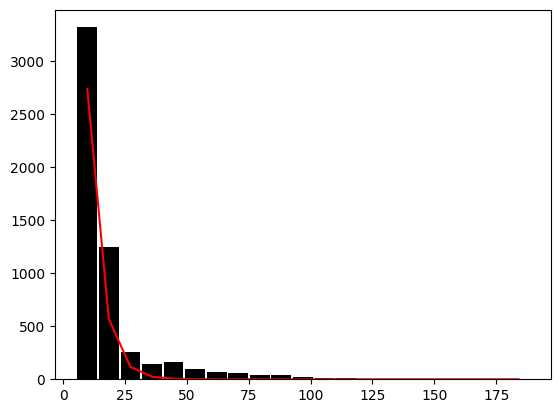

In [9]:
# 元の直線の Fitting に合わせる（全体の値に比較的忠実に従った Fitting）

# 近似曲線の Parameter を算出する
import numpy as np

# Parameter 設定
epsiron = 1  # x_hist の値が 0 だった場合、log をとると負の無限大に発散してしまうため、回避するために足しあわせる便宜上の値
num = 3  # Fitting の区間を全体ではなく num で指定

# 変数設定
t = np.zeros(len(t_hist) - 1)  # t_hist は、各区間の端点を表すため、区間の中心点を表す t に変換
for i in range(len(t_hist) - 1):
    t[i] = (t_hist[i] + t_hist[i + 1]) / 2

# Fitting（最小二乗近似）による Parameter の算出
a, b = np.polyfit(t[1:num], np.log(x_hist[1:num]), 1)
    # log p(x) = ax + b の Parameter の a, b を同時に求める
    # x には t を指定
    # y には x_hist の log をとったものである np.log(x_hist[1:num]) を指定
    # w  x_hist[1:num] を指定し縦軸の値が大きいほど近似曲線に Fitting する際の重みを強めるように指定

# Fitting曲線（直線）の描画
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = a * t[i] + b
plt.plot(t_hist[1:], np.log(x_hist + epsiron), marker='.', color='k')
plt.plot(t, xt, color='r')
plt.show()

# 近似曲線を描く
import math

t = t_hist[1:]
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = math.exp(a * t[i] + b)

plt.bar(t_hist[1:], x_hist, width=8, color='k')
plt.plot(t, xt, color='r')
plt.show()

近似曲線を描く場合は、
- なぜその曲線を描いたのか
- どのように描いたのか
- その曲線によってどのような意味を伝えたいのか

が重要。描いた近似曲線を自分自身が理解していないと、Data 対する誤った理解に繋がる。

## 1-6. Plan ごとに Data を抽出してみよう
顧Plan A から D までどのようなものを選択するのか客の行動がどのように変化したかを分析する。

In [10]:
# Plan ごとに Data を抽出を行なう
plans = ['A', 'B', 'C', 'D']
for plan in plans:
    display(df_info[df_info['プラン'] == plan])

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:12:22,111504,青山 零,A,15000
2018-11-01 00:18:26,114882,山岸 淳,A,15000
2018-11-01 00:20:47,110865,石田 和也,A,15000
2018-11-01 00:21:52,110069,山岸 聡太郎,A,15000
2018-11-01 15:02:07,111430,山田 明美,A,15000
...,...,...,...,...
2020-10-31 22:14:38,110004,山岸 健一,A,3000
2020-10-31 23:38:51,110049,吉本 篤司,A,3000
2020-10-31 23:42:12,110127,喜嶋 浩,A,3000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:02:21,110034,若松 花子,B,19000
2018-11-01 00:08:41,110169,坂本 直人,B,19000
2018-11-01 00:14:56,110482,津田 舞,B,19000
2018-11-01 00:46:21,110173,井高 知実,B,19000
2018-11-01 00:55:41,110549,加藤 英樹,B,19000
...,...,...,...,...
2020-10-31 18:15:30,110195,加納 修平,B,7000
2020-10-31 21:35:22,111032,廣川 英樹,B,7000
2020-10-31 22:02:59,110579,桐山 さゆり,B,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:46:03,112171,小泉 美加子,C,19000
2018-11-01 15:01:20,114476,青山 直樹,C,19000
2018-11-01 15:03:31,113109,田辺 翔太,C,19000
2018-11-01 15:33:46,111086,加藤 裕美子,C,19000
2018-11-01 15:34:55,113560,中村 くみ子,C,19000
...,...,...,...,...
2020-10-31 20:52:00,110095,山口 太一,C,7000
2020-10-31 21:07:39,110061,田中 里佳,C,7000
2020-10-31 22:00:30,110010,山田 京助,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:03:10,112804,津田 美加子,D,20000
2018-11-01 00:06:19,110275,吉本 美加子,D,20000
2018-11-01 00:27:19,112588,吉田 和也,D,20000
2018-11-01 00:32:59,110424,近藤 裕樹,D,20000
2018-11-01 00:38:43,110391,井高 知実,D,20000
...,...,...,...,...
2020-10-31 22:08:15,110427,三宅 直人,D,8000
2020-10-31 22:08:30,115019,工藤 陽子,D,8000
2020-10-31 22:40:34,110398,木村 花子,D,8000


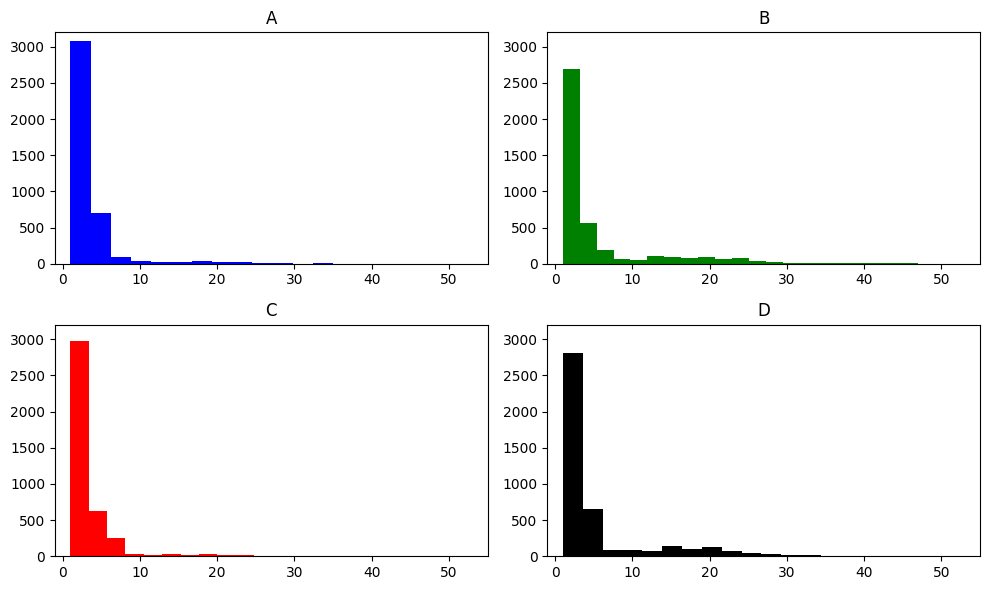

In [11]:
# Plan ごとに Histogram 表示を行なう
x_plans = []
for plan in plans:
    df_plan = df_info[df_info['プラン'] == plan]
    x_plans.append(df_plan['顧客ID'].value_counts())

fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(10, 6))
axes[0, 0].set_title('A')
axes[0, 0].hist(x_plans[0], 21, color='b')
axes[0, 0].set_ylim(0, 3200)
axes[0, 0].set_xlim(-1, 55)
axes[0, 1].set_title('B')
axes[0, 1].hist(x_plans[1], 21, color='g')
axes[0, 1].set_ylim(0, 3200)
axes[0, 1].set_xlim(-1, 55)
axes[1, 0].set_title('C')
axes[1, 0].hist(x_plans[2], 21, color='r')
axes[1, 0].set_ylim(0, 3200)
axes[1, 0].set_xlim(-1, 55)
axes[1, 1].set_title('D')
axes[1, 1].hist(x_plans[3], 21, color='k')
axes[1, 1].set_ylim(0, 3200)
axes[1, 1].set_xlim(-1, 55)

plt.show()

Plan ごとに見ても、べき分布に従っている。

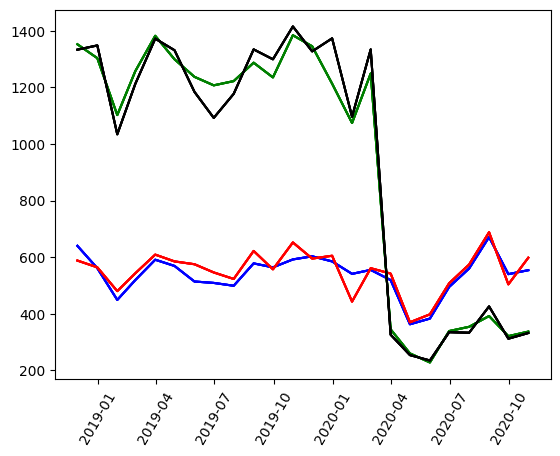

In [12]:
# Plan ごとの毎月の利用者数を表示する
plans = {'A': 'b', 'B': 'g', 'C': 'r', 'D': 'k'}
for plan, color in plans.items():
    plt.plot(df_info[df_info['プラン'] == plan].resample('M').count(), color=color)
    plt.xticks(rotation=60)

plt.show()

Plan ごとの推移より
- Plan: B/D (ともに朝夕食付)について感染症の流行を強く受けている
- Plan: A/C (ともに朝夕食なし)についてはほぼ影響を受けていない

=> 以上より
「利用者は感染症の影響で Restaurant などの密室をなるべく避けるようになったが、Remote-work を行なう新規顧客の獲得などによって、朝夕食のない Plan についてはその影響を最小限にとどめられたのではないか」と予想を行なうことができる。

## 1-7. 大口顧客の行動を分析してみよう
ここまでは、時系列や分布など Macro の様子を確認してきたが、より Micro な個人に近い情報を確認していく。
少ない数ではあるが極めて利用頻度の高い「大口顧客」の分析を行なう。

In [13]:
# 利用頻度の上位10名の情報を出力する
for i_rank in range(10):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    display(df_info[df_info['顧客ID'] == i])

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-03 19:03:50,110067,石田 知実,B,19000
2018-11-03 23:35:27,110067,石田 知実,B,19000
2018-11-07 19:15:07,110067,石田 知実,D,20000
2018-11-14 23:01:12,110067,石田 知実,B,19000
2018-11-20 17:58:54,110067,石田 知実,D,20000
...,...,...,...,...
2020-10-19 22:53:41,110067,石田 知実,D,8000
2020-10-22 15:22:04,110067,石田 知実,A,3000
2020-10-22 18:45:23,110067,石田 知実,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-02 21:26:41,110043,斉藤 あすか,A,15000
2018-11-05 16:32:52,110043,斉藤 あすか,B,19000
2018-11-17 19:46:04,110043,斉藤 あすか,B,19000
2018-11-23 16:11:16,110043,斉藤 あすか,C,19000
2018-11-24 22:38:48,110043,斉藤 あすか,B,19000
...,...,...,...,...
2020-10-18 15:07:52,110043,斉藤 あすか,C,7000
2020-10-21 15:37:46,110043,斉藤 あすか,A,3000
2020-10-21 17:08:25,110043,斉藤 あすか,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:21:52,110069,山岸 聡太郎,A,15000
2018-11-04 15:43:10,110069,山岸 聡太郎,B,19000
2018-11-07 15:10:04,110069,山岸 聡太郎,C,19000
2018-11-08 18:19:39,110069,山岸 聡太郎,B,19000
2018-11-10 18:13:26,110069,山岸 聡太郎,D,20000
...,...,...,...,...
2020-10-15 23:55:48,110069,山岸 聡太郎,A,3000
2020-10-17 21:53:22,110069,山岸 聡太郎,C,7000
2020-10-19 18:20:53,110069,山岸 聡太郎,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 23:25:40,110159,中村 陽子,D,20000
2018-11-03 16:55:48,110159,中村 陽子,B,19000
2018-11-09 18:41:04,110159,中村 陽子,A,15000
2018-11-12 21:22:19,110159,中村 陽子,D,20000
2018-11-20 15:57:06,110159,中村 陽子,A,15000
...,...,...,...,...
2020-10-01 00:31:04,110159,中村 陽子,C,7000
2020-10-01 00:54:54,110159,中村 陽子,C,7000
2020-10-20 16:36:03,110159,中村 陽子,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-02 21:22:44,110149,加藤 洋介,D,20000
2018-11-07 23:02:21,110149,加藤 洋介,D,20000
2018-11-10 20:02:30,110149,加藤 洋介,B,19000
2018-11-13 20:07:09,110149,加藤 洋介,D,20000
2018-11-14 00:49:42,110149,加藤 洋介,D,20000
...,...,...,...,...
2020-09-16 15:32:17,110149,加藤 洋介,B,7000
2020-10-05 15:38:16,110149,加藤 洋介,A,3000
2020-10-05 16:48:15,110149,加藤 洋介,D,8000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-04 15:38:53,110166,中村 桃子,C,19000
2018-11-09 22:14:27,110166,中村 桃子,B,19000
2018-11-10 23:11:36,110166,中村 桃子,D,20000
2018-11-16 17:55:30,110166,中村 桃子,D,20000
2018-11-27 18:54:10,110166,中村 桃子,B,19000
...,...,...,...,...
2020-10-14 22:26:35,110166,中村 桃子,A,3000
2020-10-17 00:40:11,110166,中村 桃子,C,7000
2020-10-23 18:15:03,110166,中村 桃子,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-10 15:02:44,110163,山口 翔太,D,20000
2018-11-16 19:27:52,110163,山口 翔太,D,20000
2018-12-14 20:07:00,110163,山口 翔太,D,20000
2018-12-15 00:34:59,110163,山口 翔太,B,19000
2019-01-08 22:34:59,110163,山口 翔太,D,18000
...,...,...,...,...
2020-10-12 19:22:25,110163,山口 翔太,C,7000
2020-10-13 20:43:18,110163,山口 翔太,A,3000
2020-10-16 16:22:16,110163,山口 翔太,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-13 17:53:51,110039,井上 晃,D,20000
2018-11-22 19:43:30,110039,井上 晃,B,19000
2018-12-04 22:11:38,110039,井上 晃,D,20000
2018-12-13 21:02:04,110039,井上 晃,D,20000
2019-01-19 15:55:06,110039,井上 晃,D,18000
...,...,...,...,...
2020-10-14 19:27:34,110039,井上 晃,C,7000
2020-10-24 18:46:32,110039,井上 晃,A,3000
2020-10-24 18:48:22,110039,井上 晃,A,3000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-19 17:34:37,109996,山本 知実,B,19000
2018-11-23 22:42:06,109996,山本 知実,D,20000
2018-11-24 16:10:08,109996,山本 知実,D,20000
2018-12-05 16:00:53,109996,山本 知実,B,19000
2018-12-11 19:04:46,109996,山本 知実,B,19000
...,...,...,...,...
2020-10-25 19:49:43,109996,山本 知実,C,7000
2020-10-27 16:58:40,109996,山本 知実,C,7000
2020-10-27 19:12:06,109996,山本 知実,C,7000


,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-03 00:52:42,110091,桐山 英樹,B,19000
2018-11-06 16:40:38,110091,桐山 英樹,D,20000
2018-11-08 16:19:26,110091,桐山 英樹,B,19000
2018-11-27 18:12:50,110091,桐山 英樹,D,20000
2018-11-27 19:30:20,110091,桐山 英樹,B,19000
...,...,...,...,...
2020-10-08 22:36:17,110091,桐山 英樹,C,7000
2020-10-15 18:02:24,110091,桐山 英樹,C,7000
2020-10-27 23:50:26,110091,桐山 英樹,C,7000


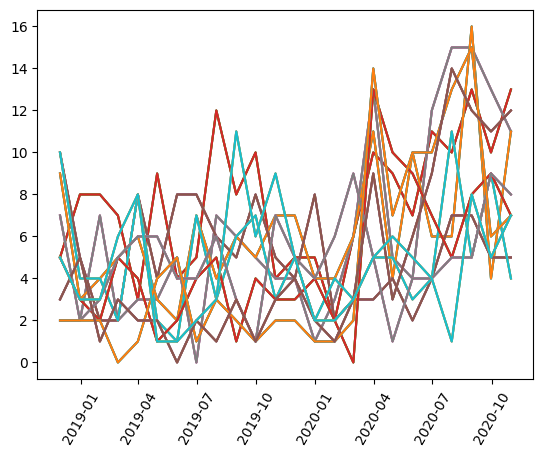

In [14]:
# 利用頻度が 1~10 位の時系列表示を行なう
for i_rank in range(10):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    plt.plot(df_info[df_info['顧客ID'] == i].resample('M').count())
    plt.xticks(rotation=60)

plt.show()

上位 1~10 は、感染症流行後にむしろ利用頻度が増加しているものが見受けられる。

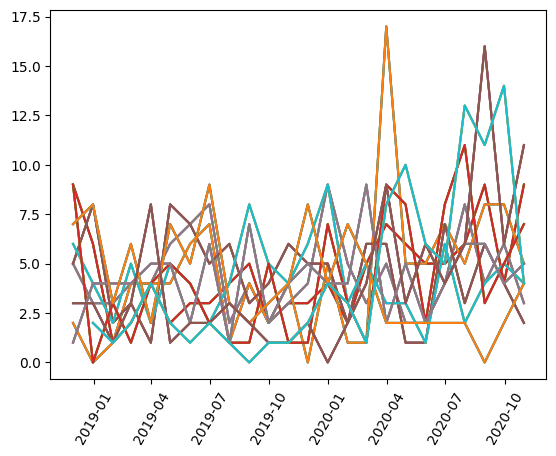

In [15]:
# 利用頻度が 11~20位の時系列表示を行なう
for i_rank in range(10, 20):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    plt.plot(df_info[df_info['顧客ID'] == i].resample('M').count())
    plt.xticks(rotation=60)

plt.show()

11~20位は、一定期間に突出しているものがあるものの、感染症流行前後では横ばいのものも見られる。

1～10, 11～20位の時系列 Data より感染症流行前後での利用者の動向に特徴が見られそうな為、この傾向をより詳細に見ていくことにする。

## 1-8. 感染症流行前後の顧客の行動を分析してみよう
感染症流行前後を2020年03月01日前後とし、その前後で大口顧客ひとりひとりの累積利用回数を可視化してみる。
そのため
1. 感染症流行前後で Data を分割
2. それぞれの Data の累積利用回数を算出

を行なう。

In [16]:
# Index を reset する
df_info = df_info.reset_index()  # 「日時」情報が Column ではなく Index になっている為、日時で Data 分割を行なえるようにする為、reset し「日時」情報を Column として取り扱えるようにする。

In [17]:
# 感染症前後の Data を分離（分割）する
import datetime as dt

target_date = dt.datetime(2020, 3, 1)
df_info_pre = df_info[df_info['日時'] < target_date]
df_info_post = df_info[df_info['日時'] >= target_date]
display(df_info_pre)
print(len(df_info_pre) + len(df_info_post), len(df_info))  # 確認のため、要素数がズレていないか検算する

,日時,顧客ID,宿泊者名,プラン,金額
0,2018-11-01 00:02:21,110034,若松 花子,B,19000
1,2018-11-01 00:03:10,112804,津田 美加子,D,20000
2,2018-11-01 00:06:19,110275,吉本 美加子,D,20000
3,2018-11-01 00:08:41,110169,坂本 直人,B,19000
4,2018-11-01 00:12:22,111504,青山 零,A,15000
...,...,...,...,...,...
58321,2020-02-29 23:49:54,111270,中津川 里佳,C,19000
58322,2020-02-29 23:52:14,112251,田中 真綾,B,19000
58323,2020-02-29 23:52:51,115804,井高 真綾,D,20000
58324,2020-02-29 23:53:09,112928,石田 修平,D,20000


71722 71722


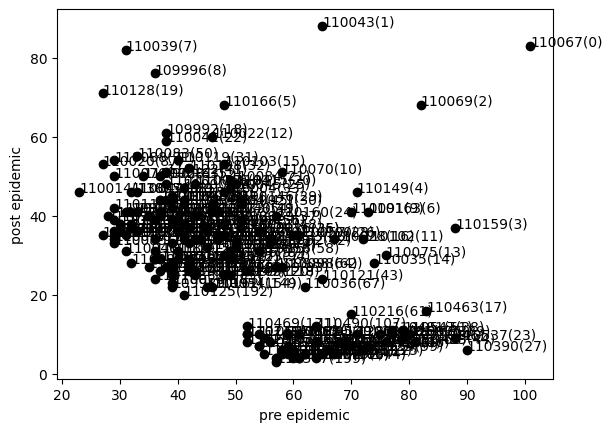

In [18]:
# 感染症流行前後の Data を二次元に Mapping する①
num = 200
count_pre_and_post = np.zeros((num, 2))
for i_rank in range(num):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    count_pre_and_post[i_rank][0] = int(df_info_pre[df_info_pre['顧客ID'] == i].count()[0])
    count_pre_and_post[i_rank][1] = int(df_info_post[df_info_post['顧客ID'] == i].count()[0])

plt.scatter(count_pre_and_post.T[0], count_pre_and_post.T[1], color='k')

for i_rank in range(num):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    text = f"{i}({i_rank})"
    plt.text(count_pre_and_post[i_rank][0], count_pre_and_post[i_rank][1], text, color='k')

plt.xlabel('pre epidemic')
plt.ylabel('post epidemic')
plt.show()

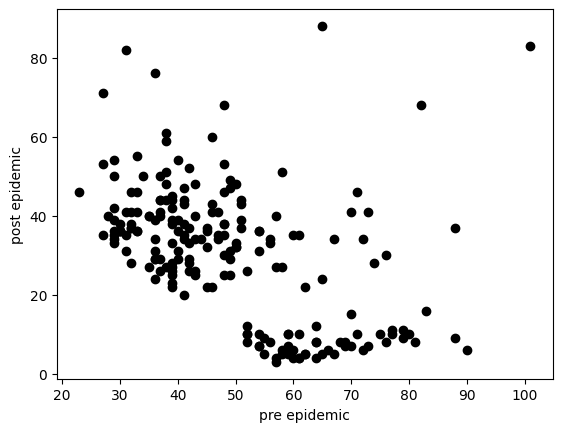

In [19]:
# 感染症流行前後の Data を二次元に Mapping する②
num = 200
count_pre_and_post = np.zeros((num, 2))
for i_rank in range(num):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    count_pre_and_post[i_rank][0] = int(df_info_pre[df_info_pre['顧客ID'] == i].count()[0])
    count_pre_and_post[i_rank][1] = int(df_info_post[df_info_post['顧客ID'] == i].count()[0])

plt.scatter(count_pre_and_post.T[0], count_pre_and_post.T[1], color='k')

# for i_rank in range(num):
#     i = df_info['顧客ID'].value_counts().index[i_rank]
#     text = f"{i}({i_rank})"
#     plt.text(count_pre_and_post[i_rank][0], count_pre_and_post[i_rank][1], text, color='k')

plt.xlabel('pre epidemic')
plt.ylabel('post epidemic')
plt.show()

感染症流行前後であまり傾向の変わらないもの（散布図の中心付近に位置するもの）も多くあるが、感染症の流行前後において極端に偏ったものがいくつか散見され利用者の傾向の違いは大きく見られる。

## 1-9. 条件による顧客の分類をしてみよう
条件にあった顧客を分類して List-up していく。

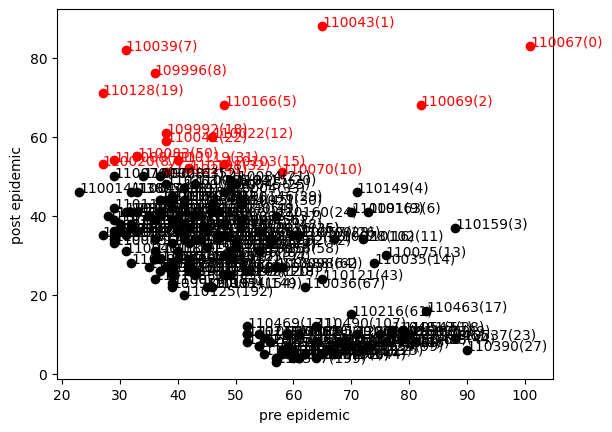

In [20]:
# 条件にあった顧客を赤色で表記する

# Parameter 設定
num = 200
threshold_post = 50  # しきい値の設定

# 感染症対策を可視化
count_pre_and_post = np.zeros((num, 2))

for i_rank in range(num):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    count_pre_and_post[i_rank][0] = int(df_info_pre[df_info_pre['顧客ID'] == i].count()[0])
    count_pre_and_post[i_rank][1] = int(df_info_post[df_info_post['顧客ID'] == i].count()[0])

for i_rank in range(num):
    i = df_info['顧客ID'].value_counts().index[i_rank]
    text = f"{i}({i_rank})"
    if count_pre_and_post[i_rank][1] > threshold_post:
        temp_color = 'r'
    else:
        temp_color = 'k'
    plt.scatter(count_pre_and_post[i_rank][0], count_pre_and_post[i_rank][1], color=temp_color)
    plt.text(count_pre_and_post[i_rank][0], count_pre_and_post[i_rank][1], text, color=temp_color)

plt.xlabel('pre epidemic')
plt.ylabel('post epidemic')
plt.show()

感染流行後の利用回数が50回を超える顧客を赤色に着色して表記。